In [ ]:
!pip install torchaudio
#Successfully installed torch-1.8.1 torchaudio-0.8.1


     |████████████████████████████████| 1.9MB 22.9MB/s 


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torch.utils.data import Dataset
import torchaudio

import pandas as pd
import numpy as np
# for plots and graphs
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import torch
path = '/content/drive/My Drive/sound Classification/'

Mounted at /content/drive


In [ ]:
file_n='UrbanSound8K.csv'
csvData = pd.read_csv(path+file_n)
print(csvData.iloc[0, :])

slice_file_name    100032-3-0-0.wav
fsID                         100032
start                             0
end                        0.317551
salience                          1
fold                              5
classID                           3
class                      dog_bark
Name: 0, dtype: object


In [ ]:
print(csvData.head())

      slice_file_name    fsID  start  ...  fold  classID             class
0    100032-3-0-0.wav  100032    0.0  ...     5        3          dog_bark
1  100263-2-0-117.wav  100263   58.5  ...     5        2  children_playing
2  100263-2-0-121.wav  100263   60.5  ...     5        2  children_playing
3  100263-2-0-126.wav  100263   63.0  ...     5        2  children_playing
4  100263-2-0-137.wav  100263   68.5  ...     5        2  children_playing

[5 rows x 8 columns]


Class Distribution:
 children_playing    1000
drilling            1000
air_conditioner     1000
engine_idling       1000
street_music        1000
jackhammer          1000
dog_bark            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64


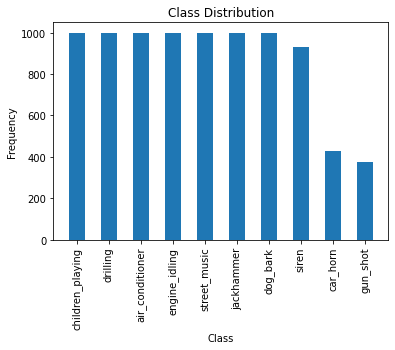

In [ ]:
#for i in range(0,len(csvData)): 
 # if(csvData['fold'] in range (1,10))
csvData['class'].value_counts()
plt.bar(csvData['class'].value_counts().index, csvData['class'].value_counts(), width=0.5, bottom=None, align='center')
plt.title('Class Distribution')
plt.xticks(rotation='vertical')
plt.xlabel('Class')
plt.ylabel('Frequency')
print('Class Distribution:\n',csvData['class'].value_counts())


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Frequency distribution per class- Urbansound8k')

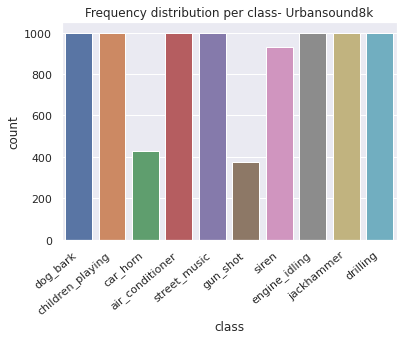

In [ ]:
sns.set_theme(style="darkgrid")
z=sns.countplot(csvData['class'])
z.set_xticklabels(z.get_xticklabels(), rotation=40, ha="right")
z.set_title("Frequency distribution per class- Urbansound8k")

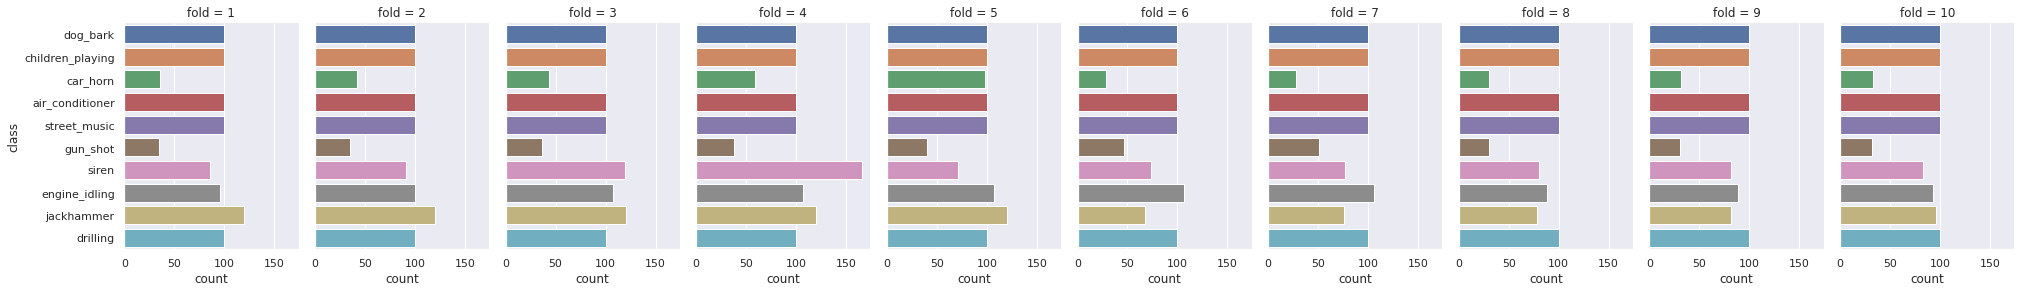

In [ ]:
g = sns.catplot(y="class", col="fold",
                data=csvData, kind="count",
                height=4, aspect=.7);
#g.set_title("Class distribution per Fold- Urbansound8k")

In [ ]:
import IPython.display as ipd
ipd.Audio(path+'/fold10/209672-3-8-0.wav')




In [ ]:
class UrbanSoundDataset(Dataset):
#rapper for the UrbanSound8K dataset
    # Argument List
    #  path to the UrbanSound8K csv file
    #  path to the UrbanSound8K audio files
    #  list of folders to use in the dataset
    
    def __init__(self, csv_path, file_path, folderList):
        csvData = pd.read_csv(csv_path)
        length=len(csvData)
        print(length) 
        #initialize lists to hold file names, labels, and folder numbers
        self.file_names = []
        self.labels = []
        self.folders = []
        #loop through the csv entries and only add entries from folders in the folder list
        for i in range(0,len(csvData)):
            if csvData.iloc[i, 5] in folderList:
                self.file_names.append(csvData.iloc[i, 0])
                self.labels.append(csvData.iloc[i, 6])
                self.folders.append(csvData.iloc[i, 5])
                
        self.file_path = file_path
       
        self.folderList = folderList
        
        
    def __getitem__(self, index):
        #format the file path and load the file
        #path = self.file_path + "/" + self.file_names[index]
        path = self.file_path + "fold" + str(self.folders[index]) + "/" + self.file_names[index]
        print(path)
        sound = torchaudio.load(path)
        #load returns a tensor with the sound data and the sampling frequency (44.1kHz for UrbanSound8K)
        soundData = torch.mean(sound[0], dim=0).unsqueeze(1) #self.mixer(sound[0])
        #downsample the audio to ~8kHz
        tempData = torch.zeros([160000, 1]) #tempData accounts for audio clips that are too short
        if soundData.numel() < 160000:
            tempData[:soundData.numel()] = soundData[:]
        else:
            tempData[:] = soundData[:160000]
        
        soundData = tempData
        soundFormatted = torch.zeros([32000, 1])
        soundFormatted[:32000] = soundData[::5] #take every fifth sample of soundData
        soundFormatted = soundFormatted.permute(1, 0)
        return soundFormatted, self.labels[index]
    
    def __len__(self):
        return len(self.file_names)

    



In [ ]:
#csv_path = './UrbanSound8K/metadata/UrbanSound8K.csv'
csv_path = path+file_n
file_path = path

train_set = UrbanSoundDataset(csv_path, file_path, range(1,10))

test_set = UrbanSoundDataset(csv_path, file_path, [10])
print("Train set size: " + str(len(train_set)))
print("Test set size: " + str(len(test_set)))



In [ ]:


train_loader = torch.utils.data.DataLoader(train_set, batch_size = 128, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 128, shuffle = True)


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv1d(1, 128, 80, 4) ## Model   1 input-> conv, Relu->  128 batch normalization 
            #                                     -> Maxpool,-> Conv->Relu->batchnorm->maxpool->
            #                               average pool->FC (512,10)->Log Softmax
        self.bn1 = nn.BatchNorm1d(128)
        
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(128, 128, 3)
        self.bn2 = nn.BatchNorm1d(128)
       
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(128, 256, 3)
        self.bn3 = nn.BatchNorm1d(256)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(256, 512, 3)
        self.bn4 = nn.BatchNorm1d(512)
        self.pool4 = nn.MaxPool1d(4)
        self.avgPool = nn.AvgPool1d(30) #input should be 512x30 so this outputs a 512x1
        self.fc1 = nn.Linear(512, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
       
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = self.avgPool(x)
        x = x.permute(0, 2, 1) #change the 512x1 to 1x512
        x = self.fc1(x)
        return F.log_softmax(x, dim = 2)

model = Net()
model.to(device)
print(model)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr = 0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.1)

In [ ]:



def train(model, epoch):

    model.train()
    n_samples = 0
    correct=0.
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data = data.to(device)
        target = target.to(device)
        data = data.requires_grad_() #set requires_grad to True for training
        n_samples += data.size()[0]          
        output = model(data)
        output = output.permute(1, 0, 2) #original output dimensions are batchSizex1x10 
        pred = output.max(2)[1] # get the index of the max log-probability
        correct += pred.eq(target).cpu().sum().item()
        loss = F.nll_loss(output[0], target) #the loss functions expects a batchSizex10 input

        loss.backward()
        optimizer.step()


        if batch_idx % log_interval == 0: #print training stats
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss/n_samples))
        train_loss.append(loss/n_samples)

        train_acc.append(100. * correct / n_samples)
      
    trainloss = {"loss": train_loss, "model":model, "trainAcc":train_acc}
    pickle.dump(trainloss, open(path+"audiotrain.pkl", "wb"))    



In [ ]:
def test(model):

    model.eval()
    correct = 0
    n_samples=0
    total=0
    for data, target in test_loader:
        data = data.to(device)
        n_samples += data.size()[0]          
        target = target.to(device)
        output = model(data)
        output = output.permute(1, 0, 2)
        pred = output.max(2)[1] # get the index of the max log-probability
        correct += pred.eq(target).cpu().sum().item()

        print('\nTest set: Accuracy: {}/{} ({:.0f}%)\n'.format(
        correct, len(test_loader.dataset),
        100. * correct / n_samples))
    
    test_acc.append(100. * correct / n_samples)

def val_test(model,epoch):

    model.eval()
    correct = 0
    
    n_samples=0
    total=0

    for batch_idx, (data, target) in enumerate(val_loader):
        data = data.to(device)
        data = data.requires_grad_() #set requires_grad to True for training
        n_samples += data.size()[0]          
        target = target.to(device)
        output = model(data)
        output = output.permute(1, 0, 2)
        loss = F.nll_loss(output[0], target) #the loss functions expects a batchSizex10 input
        pred = output.max(2)[1] # get the index of the max log-probability
        correct += pred.eq(target).cpu().sum().item()

        print('Validation Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(val_loader.dataset),
                100. * batch_idx / len(val_loader), loss/n_samples))
        print("Accuracy",100. * correct / n_samples)
    val_loss.append(loss/n_samples)
    val_acc.append(100. * correct / n_samples)

In [ ]:

train_loss=[]
train_acc=[]
train_set = UrbanSoundDataset(csv_path, file_path, range(1,4))

print("Train set size: " + str(len(train_set)))
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 128, shuffle = True)

model = Net()
model.to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr = 0.001)
PATH = path+"CNNmodel.pt"
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss = checkpoint['loss']
train_acc=checkpoint['acc']
print(train_loss)
print(train_acc)
log_interval = 20
for epoch in range(1,8):
    train(model, epoch)

EPOCH = 10
PATH = path+"CNNmodel.pt"
LOSS = train_loss
Acc=train_acc

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            'acc': Acc
            }, PATH)
#    val_test(model)
    #test(model)

In [ ]:

train_set = UrbanSoundDataset(csv_path, file_path, range(4,7))
log_interval = 20
print("Train set size: " + str(len(train_set)))
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 128, shuffle = True)
PATH = path+"CNNmodel.pt"
model = Net()
model.to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss = checkpoint['loss']
train_acc=checkpoint['acc']
print(train_loss)
print(train_acc)
#loaded = pickle.load(open(path+"audiotrain.pkl", "rb"))
#print(loaded)
#model=loaded["model"]
#train_acc=loaded["trainAcc"]
#train_loss=loaded["loss"]

for epoch in range(1,8):
    
    train(model, epoch)
EPOCH = 10
PATH = path+"CNNmodel.pt"
LOSS = train_loss
Acc=train_acc

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            'acc': Acc
            }, PATH)


In [ ]:
torch.cuda.empty_cache()
train_set = UrbanSoundDataset(csv_path, file_path, range(7,9))
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 128, shuffle = True)
print("Train set size: " + str(len(train_set)))
#loaded = pickle.load(open(path+"audiotrain.pkl", "rb"))
#print(loaded)
log_interval = 20
PATH = path+"CNNmodel.pt"
model = Net()
model.to(device)
#print(model)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss = checkpoint['loss']
train_acc=checkpoint['acc']
print(train_loss)
print(train_acc)

for epoch in range(1,8):
    
    train(model, epoch)

EPOCH = 10
PATH = path+"CNNmodel.pt"
LOSS = train_loss
Acc=train_acc

torch.save({
            'epoch': EPOCH,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            'acc': Acc
            }, PATH)


8732
Train set size: 1644
[tensor(0.0190, requires_grad=True), tensor(0.0081, requires_grad=True), tensor(0.0055, requires_grad=True), tensor(0.0038, requires_grad=True), tensor(0.0030, requires_grad=True), tensor(0.0023, requires_grad=True), tensor(0.0020, requires_grad=True), tensor(0.0017, requires_grad=True), tensor(0.0015, requires_grad=True), tensor(0.0013, requires_grad=True), tensor(0.0011, requires_grad=True), tensor(0.0011, requires_grad=True), tensor(0.0010, requires_grad=True), tensor(0.0009, requires_grad=True), tensor(0.0009, requires_grad=True), tensor(0.0008, requires_grad=True), tensor(0.0007, requires_grad=True), tensor(0.0008, requires_grad=True), tensor(0.0006, requires_grad=True), tensor(0.0006, requires_grad=True), tensor(0.0006, requires_grad=True), tensor(0.0115, requires_grad=True), tensor(0.0059, requires_grad=True), tensor(0.0042, requires_grad=True), tensor(0.0027, requires_grad=True), tensor(0.0021, requires_grad=True), tensor(0.0018, requires_grad=True), t

Text(0.5, 1.0, 'CNN Training Loss')

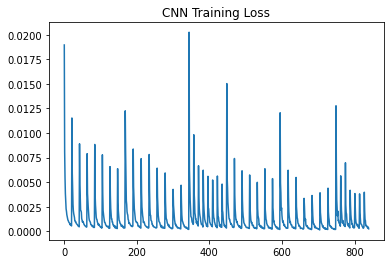

In [ ]:
 
plt.figure()
plt.plot(train_loss)
plt.title("CNN Training Loss")





Text(0.5, 1.0, 'CNN Training Accuracy ')

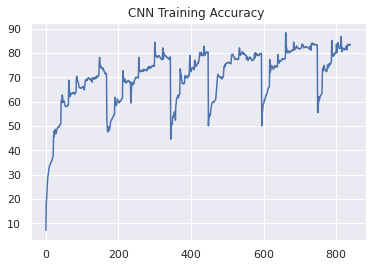

In [ ]:
sns.set_theme(style="darkgrid")
plt.figure()
plt.plot(train_acc)
plt.title("CNN Training Accuracy ")


In [ ]:
PATH = path+"CNNmodel.pt"
model = Net()
model.to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss = checkpoint['loss']


val_set = UrbanSoundDataset(csv_path, file_path, [9])


test_acc=[]
#test_loss=[]
val_loss=[]
val_acc=[]


print("Validation set size: " + str(len(val_set)))

val_loader = torch.utils.data.DataLoader(val_set, batch_size = 128, shuffle = True)

for epoch in range(1,7):
  val_test(model,epoch)



valdict = {"loss": val_loss, "model":model, "valAcc":val_acc}
pickle.dump(valdict, open(path+"audioval.pkl", "wb"))    

In [ ]:
mydict = {"model":model, "Valloss": val_loss,"valAcc":val_acc }
pickle.dump(mydict, open(path+"audioaccuracy.pkl", "wb"))    

In [ ]:
#loaded = pickle.load(open(path+"audiotrain.pkl", "rb"))
#print(loaded)
#model=loaded["model"]
#train_acc=loaded["trainAcc"]
#train_loss=loaded["loss"]
import pickle
torch.cuda.empty_cache()
PATH = path+"CNNmodel.pt"
model = Net()
model.to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss = checkpoint['loss']

test_set = UrbanSoundDataset(csv_path, file_path, [10])
#print("Train set size: " + str(len(train_set)))
print("Test set size: " + str(len(test_set)))
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 128, shuffle = True)
test_acc=[]
test(model)
mydict = {"model":model, "Valloss": val_loss,"valAcc":val_acc, "testAcc":test_acc, }
pickle.dump(mydict, open(path+"audiotest.pkl", "wb"))    

In [ ]:
PATH = path+"CNNmodel.pt"
model = Net()
model.to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr = 0.001)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
train_loss = checkpoint['loss']


In [ ]:
test_set = UrbanSoundDataset(csv_path, file_path, [10])

print("Test set size: " + str(len(test_set)))
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 128, shuffle = True)

#test_loader.dataset.classes
nb_classes = 10
#print(test_loader.classes)
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for data, target in test_loader:
        data = data.to(device)
        target = target.to(device)
        output = model(data)
        output = output.permute(1, 0, 2)
        print(target)

        pred = output.max(2)[1] # get the index of the max log-probability
        print(pred)
        for t, p in zip(target.view(-1), pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)



In [ ]:
## plot confusion matrix
#get per class accuracy
print(confusion_matrix.diag()/confusion_matrix.sum(1))


tensor([0.4500, 0.6061, 0.5900, 0.5900, 0.3700, 0.5914, 0.4688, 0.7188, 0.4819,
        0.6000])


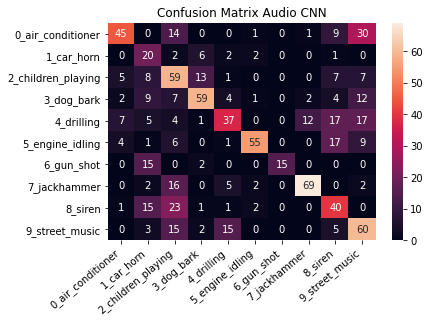

In [ ]:
#cf=loaded["confusionmatrix"]
#print(cf)
class_names=['0_air_conditioner', '1_car_horn', '2_children_playing', '3_dog_bark', '4_drilling', '5_engine_idling', '6_gun_shot', '7_jackhammer', '8_siren', '9_street_music']
import seaborn as sns
ax = plt.axes()
z=sns.heatmap(confusion_matrix, annot=True, ax=ax)
z.set_xticklabels(class_names, rotation=40, ha="right")
z.set_yticklabels(class_names,rotation=60,ha="right")
#sns.heatmap(cf/np.sum(cf), annot=True, fmt='float', cmap='Blues')
z.set_title('Confusion Matrix Audio CNN')
plt.show()